In [230]:
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import json  
import mpl_toolkits
import os
import pickle
import glob
import re
import itertools
from PIL import Image
import time


from skimage import color
from skimage.feature import hog

from skimage.transform import pyramid_gaussian
from skimage.io import imread
from skimage.feature import hog

import cv2
import argparse as ap


import sklearn as sklearn
from sklearn.metrics import confusion_matrix
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier as MLPC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn import model_selection
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc


import pyimagesearch.imutils as imutils
from pyimagesearch.helpers import pyramid
from pyimagesearch.helpers import sliding_window

## Bring in images

In [72]:
os.listdir("shipsnet_data/shipsnet");
path =r'/Users/mayamidzik/cv/shipsnet/shipsnet_data/shipsnet'
boats = glob.glob(os.path.join(path,'1*.png'))
no_boats = glob.glob(os.path.join(path,'0*.png'))
boats.extend(no_boats)

In [73]:
image_data = []
image_tag = []

def makeImageDataTagArray(files_list):
    positive = re.compile("/Users/mayamidzik/cv/shipsnet/shipsnet_data/shipsnet/1.*")
    negative = re.compile("/Users/mayamidzik/cv/shipsnet/shipsnet_data/shipsnet/0.*")
    for i in files_list:
        if positive.match(i):
            image_tag.append(1)
        if negative.match(i):
            image_tag.append(0)
        img = Image.open(i)
        arr = np.array(img)
        image_data.append(arr)
        
makeImageDataTagArray(boats)

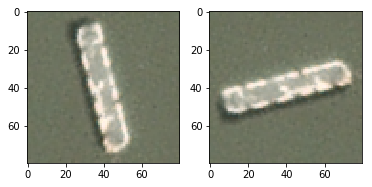

In [101]:
plt.subplot(1,2,1)
plt.imshow(image_data[200])
plt.subplot(1,2,2)
plt.imshow(np.rot90(image_data[200]));

## normalize images

In [152]:
def normalize(img_array):
    image_mean = np.mean(img_array)
    normalized_image = img_array / image_mean
    return normalized_image

In [173]:
norm_images = []
for image_array in image_data:
    norm = normalize(image_array)
    norm_images.append(norm)

In [178]:
norm_images_array = np.asarray(norm_images)

## Run SVM with normalized images

In [158]:
def make_vector(image_list):
    vectors = []
    for image in image_list:
        vector = np.ravel(image)
        vectors.append(vector)
    return np.array(vectors)

In [201]:
x_vect = make_vector(image_data)
x_norm_vect = make_vector(norm_images_array)
y_vect = np.ravel(image_tag)


In [202]:
xtrain, xtest, ytrain, ytest = train_test_split(x_vect, y_vect, test_size=0.2, random_state = 1234, stratify = y_vect, shuffle = True)
xnormtrain, xnormtest, ytrain, ytest = train_test_split(x_norm_vect, y_vect, test_size=0.2, random_state = 1234, stratify = y_vect, shuffle = True)



In [263]:
def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def test_model(model, xtrain, ytrain, xtest, ytest):
    
    start_time = time.time()
    clf = model.fit(xtrain, ytrain)
    train_acc=clf.score(xtrain, ytrain)
    test_acc=clf.score(xtest,ytest)
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))

    y_true = ytest
    y_pred = clf.predict(xtest)

    conf = confusion_matrix(y_true, y_pred)
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
    print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
    print ("Specificity:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[1, 0])))


    cm=confusion_matrix(y_true, y_pred, labels=None)

    plt.figure()
    plot_confusion_matrix(cm)
    return model

    print("--- %s seconds ---" % (time.time() - start_time))
    


Training Data Accuracy: 1.00
Test Data Accuracy:     0.94
[[400  20]
 [ 11 129]]


Precision:              0.97
Recall:                 0.95
Specificity:              0.92
--- 211.10239005088806 seconds ---


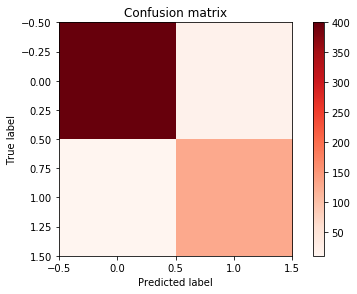

In [282]:
#SVC
svc = SVC(kernel = 'poly',degree = 3, probability=True)
start_time = time.time()
clf = svc.fit(xtrain, ytrain)
train_acc=clf.score(xtrain, ytrain)
test_acc=clf.score(xtest,ytest)
print("Training Data Accuracy: %0.2f" %(train_acc))
print("Test Data Accuracy:     %0.2f" %(test_acc))

y_true = ytest
y_pred = clf.predict(xtest)

conf = confusion_matrix(y_true, y_pred)

print(conf)

print ('\n')
print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
print ("Specificity:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[1, 0])))


cm=confusion_matrix(y_true, y_pred, labels=None)

plt.figure()
plot_confusion_matrix(cm)

print("--- %s seconds ---" % (time.time() - start_time))

In [270]:
y_score=clf.predict_proba(xtest)[:,1]


Text(0,0.5,'TPR')

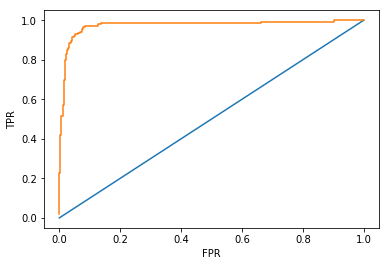

In [271]:
fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

In [277]:
fpr

array([0.        , 0.        , 0.00238095, 0.00238095, 0.0047619 ,
       0.0047619 , 0.00714286, 0.00714286, 0.01190476, 0.01190476,
       0.01428571, 0.01428571, 0.01666667, 0.01666667, 0.01904762,
       0.01904762, 0.02142857, 0.02142857, 0.02380952, 0.02380952,
       0.02619048, 0.02619048, 0.02857143, 0.02857143, 0.03095238,
       0.03095238, 0.03333333, 0.03333333, 0.03809524, 0.03809524,
       0.04047619, 0.04047619, 0.04285714, 0.04285714, 0.04761905,
       0.04761905, 0.05238095, 0.05238095, 0.06190476, 0.06190476,
       0.06904762, 0.06904762, 0.07619048, 0.07619048, 0.07857143,
       0.07857143, 0.08571429, 0.08571429, 0.12619048, 0.12619048,
       0.13571429, 0.13571429, 0.66190476, 0.66190476, 0.90238095,
       0.90238095, 0.98571429, 1.        ])

## Tune SVM model

In [273]:
#define hyperparameters
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
tuned_parameters = [{'kernel': ['rbf'], 'gamma': gammas,
                     'C': Cs},
                   {'kernel': ['poly'], 'degree':[2,3,4], 'gamma': gammas,
                     'C': Cs}]

In [ ]:
scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(xtrain, ytrain)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    with open('gridResults.pkl', 'wb') as picklefile:
        pickle.dump(clf, picklefile)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = ytest, clf.predict(xtest)
    print(classification_report(y_true, y_pred))
    print()

# Test sliding window

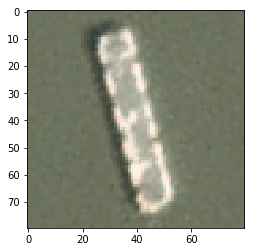

In [223]:
plt.imshow(image_data[200])

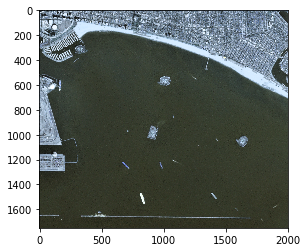

In [232]:
scene = cv2.imread('shipsnet_data/scenes/lb_1.jpg')
plt.imshow(scene)

In [237]:
(winW, winH) = (80, 80)

windows = []
for (x, y, window) in sliding_window(scene, stepSize=20, windowSize=(winW, winH)):
    if window.shape[0] != winH or window.shape[1] != winW:
        continue
    windows.append(window)

In [242]:
clf = svc_model

In [243]:
def make_vector(image_list):
    vectors = []
    for image in image_list:
        vector = np.ravel(image)
        vectors.append(vector)
    return vectors
x_image = make_vector(windows)

In [245]:
y_pred = clf.predict(x_image)

In [249]:
d = {'vector': x_image, 'predicted': y_pred}
df = pd.DataFrame(data = d)

In [250]:
found_boats = df[df['predicted']==1]

In [251]:
found_boats

,predicted,vector
2,1,"[110, 131, 148, 140, 157, 182, 126, 143, 166, ..."
4,1,"[175, 196, 218, 184, 204, 226, 173, 193, 215, ..."
5,1,"[33, 42, 46, 89, 111, 129, 136, 157, 186, 139,..."
6,1,"[57, 65, 69, 51, 60, 63, 48, 54, 55, 58, 66, 6..."
8,1,"[174, 194, 211, 154, 174, 188, 169, 187, 203, ..."
9,1,"[149, 164, 181, 151, 168, 187, 158, 175, 197, ..."
10,1,"[98, 109, 114, 142, 160, 176, 175, 190, 209, 1..."
19,1,"[107, 127, 144, 131, 151, 171, 160, 177, 202, ..."
20,1,"[126, 151, 176, 111, 137, 163, 85, 108, 127, 1..."
21,1,"[114, 132, 148, 101, 116, 127, 108, 124, 135, ..."


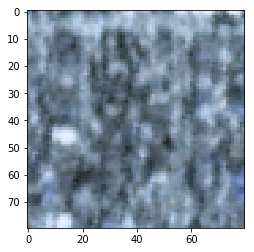

In [280]:
plt.imshow(windows[69])